In [1]:
!nvidia-smi

Thu Jul 14 01:38:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:17:00.0 Off |                  N/A |
|  0%   41C    P2    60W / 250W |   5506MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:65:00.0 Off |                  N/A |
| 49%   66C    P2   103W / 250W |   2463MiB / 11176MiB |     87%      Default |
+-------------------------------+----------------------+----------------------+
        

In [1]:
import argparse
import importlib
import os

import numpy as np
from sklearn.model_selection import train_test_split

import data_reader
from bat_trainer import BATTrainer

parser = argparse.ArgumentParser()
parser.add_argument('--model-name', type=str)
parser.add_argument('--model-path', type=str)
parser.add_argument('--limit', type=int, default=None)
parser.add_argument('--random-label', type=bool, default=False)
parser.add_argument('--max-value', type=int, default=None)  # ignore data with value greater than this
parser.add_argument('--clip-value', type=int, default=None)  # clip to this value
parser.add_argument('--epochs', type=int, default=150)
parser.add_argument('--batch-size', type=int, default=512)
parser.add_argument('--optimizer', type=str, default='adam', choices=['adam', 'sgd'])
parser.add_argument('--scheduler', type=str, default=None, choices=['cyclic', 'multistep'])
parser.add_argument('--lr-min', type=float, default=None)
parser.add_argument('--lr-max', type=float, default=None)
parser.add_argument('--momentum', type=float, default=0)
parser.add_argument('--weight-decay', type=float, default=0)
parser.add_argument('--epsilon', type=float, default=0)
parser.add_argument('--iterations', type=int, default=0)
parser.add_argument('--from-model', type=str, default=None)
parser.add_argument('--validation', type=str, default='random', choices=['random', 'loov'])
parser.add_argument('--loo', type=int, nargs='+')
parser.add_argument('--adv-batch', type=int, default=1)  # whether or not train batch model adversarially

# args = parser.parse_args()

data = data_reader.Data()
# if args.clip_value:
#     data = data.clip_value(args.clip_value)
# if args.max_value:
#     data = data.filter_by_x(args.max_value)

data = data.drop_first_n_second(3).binary().filter_y(valence=0).subsample(3).first_n_channels(32)
print(data.x.shape)
print(data.y.shape)
print(data.s.shape)

subjects = data.subjects

# if args.validation == 'random':
if True:
    data = train_test_split(data.x, data.y, data.s, test_size=0.2, random_state=0, shuffle=True)
    data_train_x = data[0]
    data_test_x = data[1]
    data_train_y = data[2]
    data_test_y = data[3]
    data_train_s = data[4]
    data_test_s = data[5]

else:
    test_data = data.filter_by_subject(6)
    train_data = data.filter_by_subject(6, invert=True)
    data_train_x = train_data.x
    data_test_x = test_data.x
    data_train_y = train_data.y
    data_test_y = test_data.y
    data_train_s = train_data.s
    data_test_s = test_data.s
    for i in range(len(data_train_s)):
        if data_train_s[i] > 5:
            data_train_s[i] -= 1
    for i in range(len(data_test_s)):
        if data_test_s[i] > 5:
            data_test_s[i] -= 1    

a, b, c = data_train_x.shape
data_train_x = data_train_x.reshape((a, 1, b, c)).astype(np.float)
data_train_y = data_train_y.astype(np.int)[:, 1]  # arousal
data_train_s = data_train_s.astype(np.int) - 1
a, b, c = data_test_x.shape
data_test_x = data_test_x.reshape((a, 1, b, c)).astype(np.float)
data_test_y = data_test_y.astype(np.int)[:, 1]  # arousal
data_test_s = data_test_s.astype(np.int) - 1

# if args.limit:
#     data_train_x = data_test_x = data_train_x[:args.limit]
#     data_train_y = data_test_y = data_train_y[:args.limit]
#     data_train_s = data_test_s = data_train_s[:args.limit]

# if args.random_label:
#     data_test_y = np.random.randint(0, 2, size=data_test_y.shape[0])
#     data_test_s = np.random.binomial(0, subjects, size=data_test_s.shape[0])

print(data_train_x.shape)
print(data_test_x.shape)
print(data_train_y.shape)
print(data_test_y.shape)
print(data_train_s.shape)
print(data_test_s.shape)

# import numpy as np
# with open('data_train_x.npy', 'rb') as f:
#     data_train_x = np.load(f)
# with open('data_train_y.npy', 'rb') as f:
#     data_train_y = np.load(f)
# with open('data_train_s.npy', 'rb') as f:
#     data_train_s = np.load(f)  

(33176, 32, 384)
(33176, 4)
(33176,)
(26540, 1, 32, 384)
(6636, 1, 32, 384)
(26540,)
(6636,)
(26540,)
(6636,)


In [2]:
mean = data_train_x.mean(axis=0)
std = data_train_x.std(axis=0)

data_train_x = data_train_x - mean
data_train_x = data_train_x / std

data_test_x = data_test_x - mean
data_test_x = data_test_x / std
print("Done")

Done


In [3]:
import numpy
unique, counts = numpy.unique(data_train_s, return_counts=True)
dict(zip(unique, counts))

{0: 993,
 1: 821,
 2: 847,
 3: 1113,
 4: 739,
 5: 468,
 6: 553,
 7: 831,
 8: 949,
 9: 936,
 10: 743,
 11: 879,
 12: 1063,
 13: 930,
 14: 921,
 15: 1147,
 16: 848,
 17: 747,
 18: 790,
 19: 776,
 20: 881,
 21: 1013,
 22: 661,
 23: 1016,
 24: 967,
 25: 670,
 26: 448,
 27: 692,
 28: 798,
 29: 602,
 30: 785,
 31: 913}

In [70]:
bool_array = []
for i in range(len(data_train_y)):
    if data_train_s[i] in [1,2,3,4,5,6,7,8,9,10]:
        bool_array.append(True)
    else:
        bool_array.append(False)

In [71]:
some_sample_train_x = data_train_x[bool_array]
some_sample_train_y = data_train_y[bool_array]
some_sample_train_s = data_train_s[bool_array]

In [72]:
merged_train_x = some_sample_train_x.reshape(some_sample_train_x.shape[0], -1)
merged_train_x.shape

(8000, 12288)

In [73]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=300)
merged_train_x = pca.fit_transform(merged_train_x)
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(merged_train_x)
x_tsne.shape

(8000, 2)

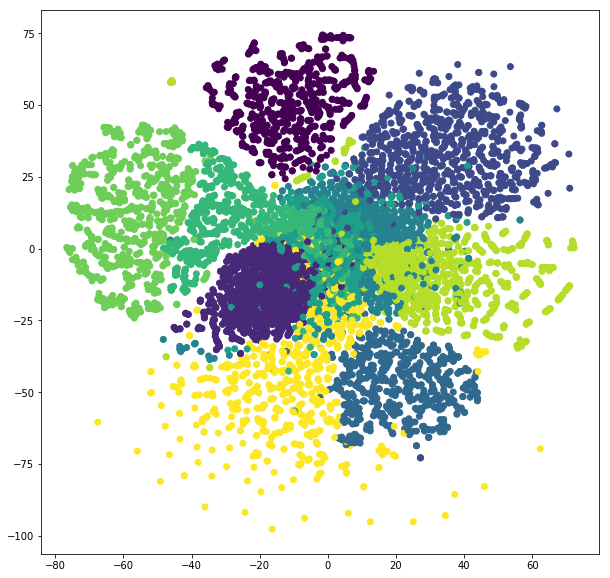

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=some_sample_train_s)
plt.show()

<div dir="ltr">
    <h3>Before Adversarial Learning</h3>    
</div>

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os

In [5]:
import torch
import torch.nn as nn


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

def ResNet18(img_channel, num_classes):
    return ResNet(block, [2, 2, 2, 2], img_channel, num_classes)
    
def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)

In [6]:
batch_size = 64
learning_rate = 0.001
num_epochs = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = ResNet18(img_channel=1, num_classes=32).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [8]:
from torch.utils.data import TensorDataset
from torch.utils.data.dataloader import DataLoader
train_dataset = TensorDataset(torch.from_numpy(data_train_x).float(), torch.from_numpy(data_train_y).long(), torch.from_numpy(data_train_s).long())
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = TensorDataset(torch.from_numpy(data_test_x).float(), torch.from_numpy(data_test_y).long(), torch.from_numpy(data_test_s).long())
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [10]:
from tqdm import tqdm
for epoch in range(num_epochs):

    for batch_idx, (data, main_targets, batch_targets) in enumerate(train_loader):
        
        data = data.to(device)
        targets = batch_targets.to(device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    
    scheduler.step()
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y, z in train_loader:
            
            x = x.to(device)
            z = z.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == z).sum()
            num_samples += predictions.size(0)

    print(f"Accuracy:{num_correct.item()/num_samples}")
    model.train()
    

Accuracy:0.8244536548605877
Accuracy:0.990881688018086
Accuracy:0.9998869630746043
Accuracy:0.9853428786737001
Accuracy:0.9999623210248682
Accuracy:0.9979276563677468


In [11]:
FILE = "model_batch_learning.pth"
torch.save(model.state_dict(), FILE)

In [9]:
FILE = "model_batch_learning.pth"
model.load_state_dict(torch.load(FILE))
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
def prepare_output(dim, target_label):
    out = torch.zeros((dim, 32))
    for i in range(len(out)):
        out[i][target_label] = 10
    return out

def change_outputs(out, target_label):
    for i in range(len(out)):
        out[i][target_label] = 500
    return out

def pgd_attack(model, images, labels, eps, iters):
    alpha = 2 / 255
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
#     outputs = prepare_output(len(class_labels), 0).to(device)
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)
        outputs = change_outputs(outputs, 0)


        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
#         images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
        images = (ori_images + eta).detach_()
            
    return images

In [12]:
!nvidia-smi

Thu Jul 14 02:02:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:17:00.0 Off |                  N/A |
|  0%   42C    P2    61W / 250W |   6221MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:65:00.0 Off |                  N/A |
| 53%   65C    P2    66W / 250W |   2463MiB / 11176MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [13]:
import numpy as np
model.eval()

epsilon_array = [0/255, 2/255, 4/255, 8/255, 10/255, 16/255, 22/255]
acc_result = []

for e in epsilon_array:
    correct = 0
    total = 0
    i = 0
    for images, class_labels, batch_labels in train_loader:

        images = pgd_attack(model, images, batch_labels, eps=e, iters=10)
        batch_labels = batch_labels.to(device)
        outputs = model(images)


        _, pre = torch.max(outputs.data, 1)

        total += len(batch_labels)
        correct += (pre == batch_labels).sum()

    #     data_train_x = np.vstack((data_train_x, images.to(device="cpu").numpy()))
    #     data_train_y = np.concatenate((data_train_y, class_labels.to(device="cpu").numpy()))
    #     data_train_s = np.concatenate((data_train_s, batch_labels.to(device="cpu").numpy()))

#         print(i)
        i += 1
        if i == 20:
            break
    print('Accuracy of Model Againest Adversarial Examples: %f %%' % (100 * float(correct) / total))
    acc_result.append(float(correct) / total)

# print('Accuracy of Model Againest Adversarial Examples: %f %%' % (100 * float(correct) / total))

Accuracy of Model Againest Adversarial Examples: 100.000000 %
Accuracy of Model Againest Adversarial Examples: 99.843750 %
Accuracy of Model Againest Adversarial Examples: 93.359375 %
Accuracy of Model Againest Adversarial Examples: 62.656250 %
Accuracy of Model Againest Adversarial Examples: 52.109375 %
Accuracy of Model Againest Adversarial Examples: 35.390625 %
Accuracy of Model Againest Adversarial Examples: 30.703125 %


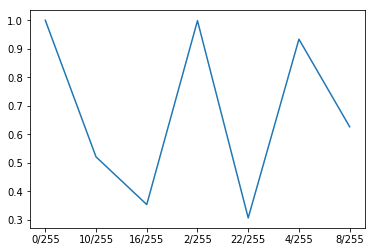

In [15]:
epsilon_array_string = ["0/255", "2/255", "4/255", "8/255", "10/255", "16/255", "22/255"]
import seaborn as sns
sns.lineplot(x=epsilon_array_string, y=acc_result)

In [53]:
adversarial_train_x = data_train_x[len(data_train_x) // 2:]
adversarial_train_y = data_train_y[len(data_train_y) // 2:]
adversarial_train_s = data_train_s[len(data_train_s) // 2:]

In [65]:
!nvidia-smi

Tue Jul 12 05:54:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:17:00.0 Off |                  N/A |
| 41%   58C    P2    86W / 250W |  10392MiB / 11178MiB |     21%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:65:00.0 Off |                  N/A |
| 56%   69C    P2    84W / 250W |   9665MiB / 11176MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
        

In [66]:
data_train_x.shape

(65192, 1, 32, 384)

In [54]:
from torch.utils.data import TensorDataset
from torch.utils.data.dataloader import DataLoader
train_dataset = TensorDataset(torch.from_numpy(adversarial_train_x).float(), torch.from_numpy(adversarial_train_y).long(), torch.from_numpy(adversarial_train_s).long())
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = TensorDataset(torch.from_numpy(data_test_x).float(), torch.from_numpy(data_test_y).long(), torch.from_numpy(data_test_s).long())
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [55]:
num_correct = 0
num_samples = 0
model.eval()

with torch.no_grad():
    for x, y, z in train_loader:

        x = x.to(device)
        z = z.to(device)

        scores = model(x)
        _, predictions = scores.max(1)
        num_correct += (predictions == z).sum()
        num_samples += predictions.size(0)

print(f"Accuracy:{num_correct.item()/num_samples}")

Accuracy:0.4721744999386428


In [35]:
print(data_train_x.shape)
print(data_train_y.shape)
print(data_train_s.shape)

(53080, 1, 32, 384)
(53080,)
(53080,)


In [21]:
some_sample_train_x = adversarial_train_x[bool_array]
some_sample_train_y = adversarial_train_y[bool_array]
some_sample_train_s = adversarial_train_s[bool_array]

NameError: name 'bool_array' is not defined

In [41]:
bool_array = []
for i in range(26540):
    if data_train_s[i] in [1,2,3,4,5,6,7,8,9,10]:
        bool_array.append(True)
    else:
        bool_array.append(False)

In [43]:
merged_train_x = some_sample_train_x.reshape(some_sample_train_x.shape[0], -1)
merged_train_x.shape

(8000, 12288)

In [44]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=300)
merged_train_x = pca.fit_transform(merged_train_x)
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(merged_train_x)
x_tsne.shape

(8000, 2)

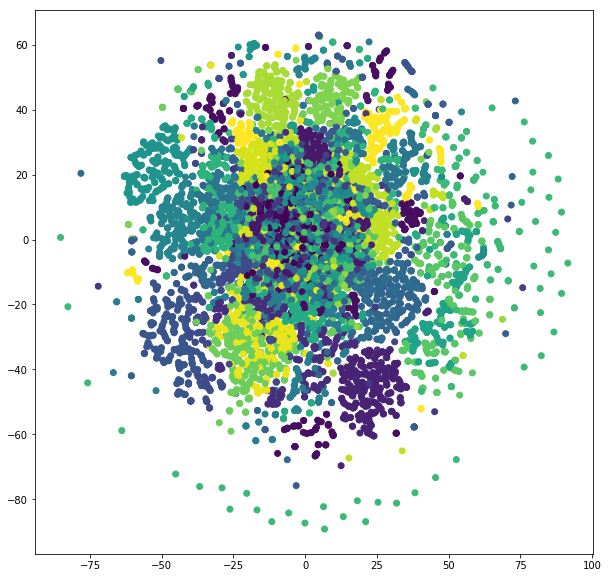

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=some_sample_train_s)
plt.show()

<div>
    <h4>Adversarial Training</h4>
    </div>

In [68]:
batch_size = 128
learning_rate = 0.001
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [69]:
model = ResNet18(img_channel=1, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [70]:
from torch.utils.data import TensorDataset
from torch.utils.data.dataloader import DataLoader
train_dataset = TensorDataset(torch.from_numpy(adversarial_train_x).float(), torch.from_numpy(adversarial_train_y).long(), torch.from_numpy(adversarial_train_s).long())
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = TensorDataset(torch.from_numpy(data_test_x).float(), torch.from_numpy(data_test_y).long(), torch.from_numpy(data_test_s).long())
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

<div dir="rtl">
    <h3>حالت درهم</h3>
    </div>

In [26]:
from tqdm import tqdm
for epoch in range(num_epochs):

    for batch_idx, (data, main_targets, batch_targets) in enumerate(train_loader):
        
        data = data.to(device)
        targets = main_targets.to(device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    
    scheduler.step()
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y, z in test_loader:
            
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    print(f"Epoch: {epoch} ---- Accuracy:{num_correct.item()/num_samples}")
    model.train()
    

Epoch: 0 ---- Accuracy:0.69333936106088
Epoch: 1 ---- Accuracy:0.7177516576250753
Epoch: 2 ---- Accuracy:0.7093128390596745
Epoch: 3 ---- Accuracy:0.7296564195298373
Epoch: 4 ---- Accuracy:0.7513562386980108
Epoch: 5 ---- Accuracy:0.7930982519590114
Epoch: 6 ---- Accuracy:0.8009342977697408
Epoch: 7 ---- Accuracy:0.8446353224834238
Epoch: 8 ---- Accuracy:0.8622664255575648
Epoch: 9 ---- Accuracy:0.8509644364074744
Epoch: 10 ---- Accuracy:0.8746232670283303
Epoch: 11 ---- Accuracy:0.8811030741410488
Epoch: 12 ---- Accuracy:0.8895418927064497
Epoch: 13 ---- Accuracy:0.8884870403857745
Epoch: 14 ---- Accuracy:0.8954189270644967
Epoch: 15 ---- Accuracy:0.9095840867992767
Epoch: 16 ---- Accuracy:0.9092827004219409
Epoch: 17 ---- Accuracy:0.9055153707052441
Epoch: 18 ---- Accuracy:0.9062688366485835
Epoch: 19 ---- Accuracy:0.9067209162145871
Epoch: 20 ---- Accuracy:0.9053646775165762
Epoch: 21 ---- Accuracy:0.918625678119349
Epoch: 22 ---- Accuracy:0.9166666666666666
Epoch: 23 ---- Accuracy:

<div dir="rtl">
    <h3>حالت کنارگذاشتن یکی از دسته ها</h3>
    </div>

In [71]:
from tqdm import tqdm
for epoch in range(num_epochs):

    for batch_idx, (data, main_targets, batch_targets) in enumerate(train_loader):
        
        data = data.to(device)
        targets = main_targets.to(device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    
    scheduler.step()
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y, z in test_loader:
            
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    print(f"Epoch: {epoch} ---- Accuracy:{num_correct.item()/num_samples}")
    model.train()
    

Epoch: 0 ---- Accuracy:0.6
Epoch: 1 ---- Accuracy:0.6068965517241379
Epoch: 2 ---- Accuracy:0.5879310344827586
Epoch: 3 ---- Accuracy:0.5896551724137931
Epoch: 4 ---- Accuracy:0.5672413793103448
Epoch: 5 ---- Accuracy:0.603448275862069
Epoch: 6 ---- Accuracy:0.5879310344827586
Epoch: 7 ---- Accuracy:0.5913793103448276
Epoch: 8 ---- Accuracy:0.5775862068965517
Epoch: 9 ---- Accuracy:0.596551724137931
Epoch: 10 ---- Accuracy:0.5844827586206897
Epoch: 11 ---- Accuracy:0.6206896551724138
Epoch: 12 ---- Accuracy:0.6086206896551725
Epoch: 13 ---- Accuracy:0.5913793103448276
Epoch: 14 ---- Accuracy:0.5793103448275863
Epoch: 15 ---- Accuracy:0.5896551724137931
Epoch: 16 ---- Accuracy:0.5775862068965517
Epoch: 17 ---- Accuracy:0.5689655172413793
Epoch: 18 ---- Accuracy:0.5620689655172414
Epoch: 19 ---- Accuracy:0.5948275862068966
Epoch: 20 ---- Accuracy:0.603448275862069
Epoch: 21 ---- Accuracy:0.5793103448275863
Epoch: 22 ---- Accuracy:0.6155172413793103
Epoch: 23 ---- Accuracy:0.5965517241379